# Basic GBM Example
This notebook contains a basic example for creating a search for GRB transients using Fermi-GBM data.

We begin by downloading a list of time tagged event (TTE) files produced for GRB 160408A (Fermi-GBM burst number 160408268). These will serve as the data input to our targeted search. At the moment, the search works with NaI detectors using files named according to **glg_tte_n?_...** where **n?** is a placeholder for the detector name. The files can be triggered TTE files from an on-board trigger or continuous TTE files produced daily. Use the continous files to search for transients occuring at any time.

In [1]:
import glob
from gdt.missions.fermi.gbm.finders import TriggerFtp, ContinuousFtp

bn = '160408268' # GBM burst identification number
ftp = TriggerFtp(bn)

# download triggered TTE
ftp.get_tte("data/gbm", dets=['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'na', 'nb'])
tte_files = sorted(glob.glob(f'data/gbm/glg_tte_n?_bn{bn}_v??.fit'))

# get the trigdat file too since it contains spacecraft position history for this burst
ftp.get_trigdat('data/gbm')
trigdat_file = glob.glob(f'data/gbm/glg_trigdat_all_bn{bn}_v??.fit')[-1]

# summary of local files
print("Downloaded TTE files:")
for file in tte_files:
    print(f"  {file}")
print(f"\nDownloaded Trigdat file: {trigdat_file}")

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Downloaded TTE files:
  data/gbm/glg_tte_n0_bn160408268_v00.fit
  data/gbm/glg_tte_n1_bn160408268_v00.fit
  data/gbm/glg_tte_n2_bn160408268_v00.fit
  data/gbm/glg_tte_n3_bn160408268_v00.fit
  data/gbm/glg_tte_n4_bn160408268_v00.fit
  data/gbm/glg_tte_n5_bn160408268_v00.fit
  data/gbm/glg_tte_n6_bn160408268_v00.fit
  data/gbm/glg_tte_n7_bn160408268_v00.fit
  data/gbm/glg_tte_n8_bn160408268_v00.fit
  data/gbm/glg_tte_n9_bn160408268_v00.fit
  data/gbm/glg_tte_na_bn160408268_v00.fit
  data/gbm/glg_tte_nb_bn160408268_v00.fit

Downloaded Trigdat file: data/gbm/glg_trigdat_all_bn160408268_v02.fit


Next we load the data into memory using the Fermi-GBM mission module from the gamma-ray data tools (GDT) package.

In [2]:
from gdt.missions.fermi.gbm.tte import GbmTte

tte_data = []
for tte_file in tte_files:
    tte = GbmTte.open(tte_file)
    tte_data.append(tte)

We then bin the data into a PHAII format using the six energy channels most useful for GRB analysis.

In [3]:
import gts

channel_edges = [8, 20, 33, 51, 85, 106, 127]
pha2_data = gts.preparePha2Data(tte_data, channel_edges)

We now need to retrieve the detector response files for the six energy channels used in our binned PHAII data. Luckily, these files are available under the **templates** directory in the gts project. The file **templates/GBM/direct/nai.npy** contains the direct responses to source locations spread across the entire sky using a a 5 deg grid for all 12 NaI detectors. The responses are available for hard (0), normal (1), and soft (2) spectral templates suitable for GRBs. This is also a blackbody spectrum (3) with kT = 10 keV for softer sources. Here we choose the first three spectral templates [0, 1, 2] since they are appropriate for most GRB analyses. See __[https://arxiv.org/abs/2308.13666](https://arxiv.org/abs/2308.13666)__ for a definition of these templates.

We ignore the impact of atmospheric scattering ont the detector responses for simplicity. See the command line tool **gbm_targeted_search.py** for a more advanced search which includes the effects of atmospheric scattering in addition to the direct responses.

In [4]:
response = gts.loadResponse('templates/GBM/direct/nai.npy', templates=[0, 1, 2], channels=[1, 2, 3, 4, 5, 6])

We also need position history information from the Fermi spacecraft in order to convert between instrument coordinates (azimuth/zenith) and astronomical coordinates (right ascension/declination) during the search. This is available in the **Trigdat** file for detected bursts. Daily position history files are also available at __[HEASARC](https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/daily)__ for use with continuous TTE.

In [5]:
from gdt.missions.fermi.gbm.trigdat import Trigdat

trigdat = Trigdat.open(trigdat_file)
spacecraft_frames = trigdat.poshist

Let's retrieve the current spacecraft position over the Earth as well as the Earth position on the sky at the on-board trigger time to show how this information can be used.

In [6]:
from gdt.missions.fermi.time import Time

trigtime = Time(pha2_data[0].trigtime, format='fermi')
frame = spacecraft_frames.at(trigtime)
print("Fermi Location: Lon %7.2f deg, Lat %7.2f deg" % (frame.earth_location.lon.deg, frame.earth_location.lat.deg))
print("Earth Location: RA  %7.2f deg, Dec %7.2f deg" % (frame.geocenter.ra.deg, frame.geocenter.dec.deg))
print("Earth Radius:   %.2f deg" % frame.earth_angular_radius.to_value('deg'))

Fermi Location: Lon -134.27 deg, Lat   25.07 deg
Earth Location: RA   338.89 deg, Dec  -25.02 deg
Earth Radius:   67.23 deg


We can now run the search since we have our data, responses, and spacecraft position.

Do this using a background fit from +/-30 seconds around the trigger time. The default fit will be a first degree polynomial. Make sure you set the range large enough to get an accurate fit.

The default search will look for gamma-ray transients with durations ranging from 0.064 to 8.192 seconds. Each duration is scanned within +/- 5 sec of the provided trigtime value using step sizes of either:
* duration / 8 for larger time windows **OR**
* 0.064 sec for time windows where duration / 8 would be smaller than the minimum 0.064 ms step size

You can adjust these settings by passing a settings dictionary using the **settings** keyword argument.

In [7]:
search = gts.runSearch(pha2_data, response, spacecraft_frames, trigtime, background_range=[-30, 30])


Using default search parameters:

Window around T0 to search:	 5 sec
Minimum search duration:	 0.064 sec
Maximum search duration:	 8.192 sec
Minimum phase step:		 0.064 sec
Number of phase steps:		 8
Minimum loglr to produce plots:	 5

Fitting backgrounds...
Background fit selection: -30 sec to 30 sec

Stat/DOF:
--------------------------- Channels ---------------------------
   1.07    1.11    1.29    1.44    0.92    0.81
   1.01    1.04    1.02    1.26    0.89    0.84
   1.01    0.95    1.04    1.24    0.81    1.06
   1.04    1.05    1.25    1.38    0.94    0.86
   1.00    0.99    1.08    1.18    0.88    0.97
   1.04    0.99    1.12    1.03    0.88    0.99
   0.98    0.95    1.02    1.06    0.83    0.98
   1.04    0.97    1.00    1.10    0.89    0.91
   1.01    1.02    0.99    1.09    0.88    0.99
   0.95    0.99    1.06    1.19    0.85    1.07
   0.96    0.93    1.03    1.06    0.82    1.04
   0.98    0.99    1.02    1.07    0.90    0.82

Running search...
Progress: 99%   
Done.

S

Now that the search has run let us plot the computed log-likelihood ratio value for every position of the 0.064-8.192 second duration windows used in the search. We refer to this type of plot as a "waterfall" plot because real GRB transients tend to produce a cascading blue feature that looks like a waterfall.

/Users/jrwood2/Software/GBM/gts/plots.py:349: RuntimeWarning: invalid value encountered in log
  color_fracs = np.log(vals-min_val)/np.log(max_val-min_val)


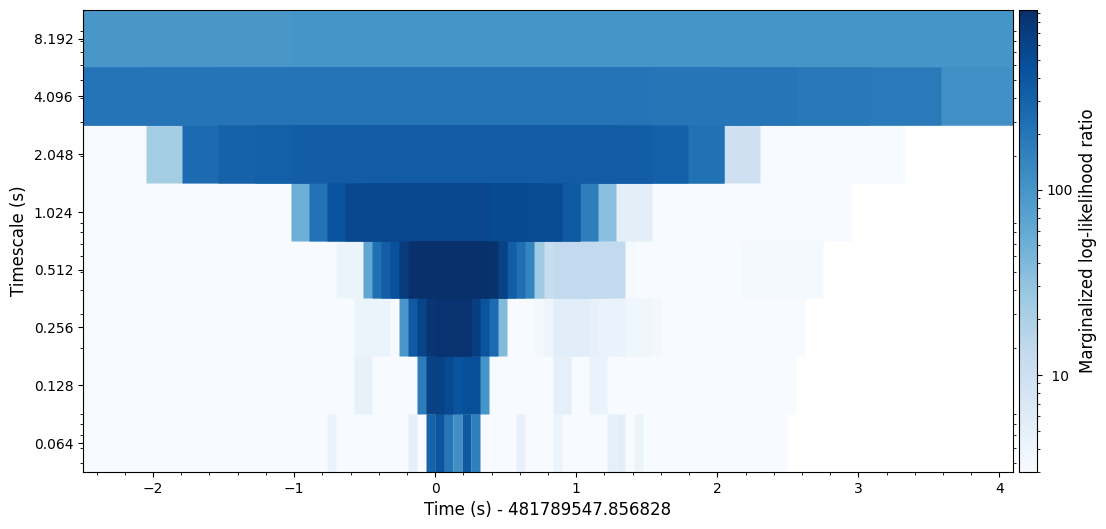

In [8]:
import plots

w = plots.Waterfall(search['results'], trigtime)
w.plot_loglr(val_min=3.0)

We can also filter the full set of results to display up to three top candidates ranked by the log-likelihood ratio.

In [9]:
# filter the results to get up to 3 top candidates
filtered_results = search['results']
# remove results with loglr < 5 since they're guaranteed to be insignificant
filtered_results = filtered_results.downselect(threshold=5, no_empty=True)
# keep result with higher SNR if it can explain an overlapping result within the 5 second search window
filtered_results = filtered_results.downselect(combine_spec=False, fixedwin=5.0)
filtered_results.write()

Total number of bins: 2
In GTI: 2
Used atmoscat: 0
Pre-filtered: 0
--------------------------------------------------------------------------------------------------------------------------------------------------
    tcent    duration  gti rock good  phi  theta  ra  dec  spec ampli  snr  snr0  snr1 chisq chisq+ sun  earth    logLR   coincLR  PE0   PE1   PE2
--------------------------------------------------------------------------------------------------------------------------------------------------
        0.128   0.512   1    0    1   60.0  10.0 117.5  68.3 0  3.74  42.5  15.4  17.8   2.3   2.5  87.0 130.1   935.07   935.43   3.3   3.3   4.4
       -0.768   2.048   1    0    1   60.0   5.0 128.1  71.7 1  1.20  20.5   8.2   9.2   1.5   1.7  89.5 130.2   202.97   203.33   2.2   2.2   3.0


Let us gather important information for the top candidate after filtering.

In [10]:
tcent = filtered_results.times[0] # central time of candidate in seconds
duration = filtered_results.durations[0] # duration of candidate in seconds
zen = filtered_results.locs_sc[1][0] # zenith angle relative to spacecraft boresight (defined by the Fermi-LAT instrument)
template = filtered_results.templates[0] # best-fit spectral template
atmoscat = 1 # set to 1 for demonstration purposes in the localization plot. Should normally be 0 when uses direct response only.

We can now plot the candidate lightcurve using summed counts from all detectors.

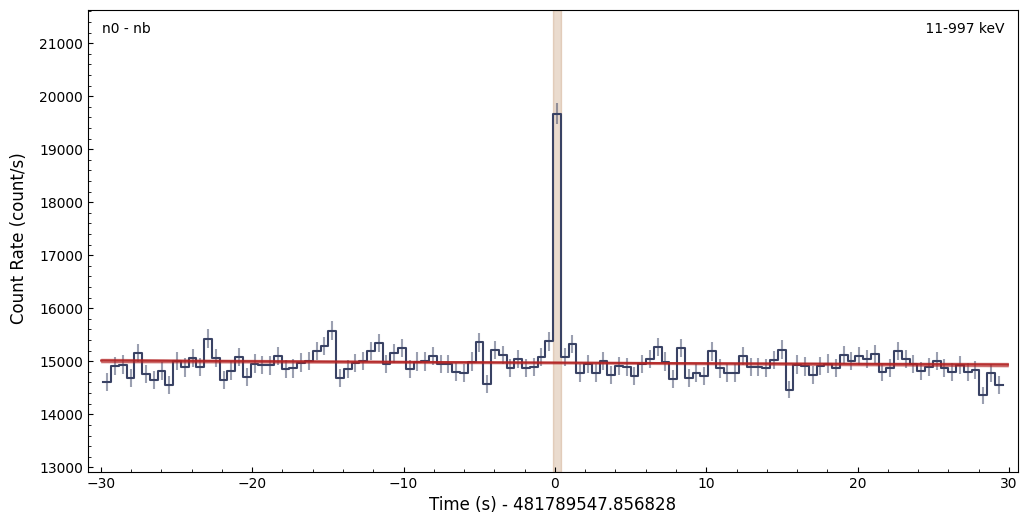

In [11]:
lcplotter = plots.TargetedLightcurves(search['data'], search['background'], trigtime)
lcplotter.plot_summed(duration, None, event_time=tcent - 0.5 * duration)

We can also create a localization, including a typical systematic error.

In [12]:
import skymap

from gdt.missions.fermi.gbm.localization import GbmHealPix

systematic = (skymap.O3_DGAUSS_Model, atmoscat, zen) 
loc = gts.createLocalization(tcent, duration, template, search, GbmHealPix, systematic, remove_earth=True)

Now plot the localization.

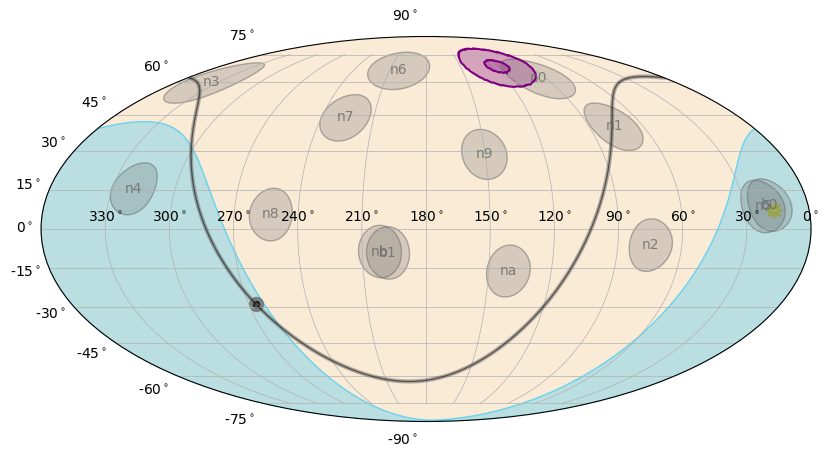

In [13]:
from gdt.core.plot.sky import EquatorialPlot

skyplot = EquatorialPlot()
skyplot.add_localization(loc, clevels=[0.90, 0.50], gradient=False)